In [12]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from Quad_tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import erf
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
from scipy.interpolate import UnivariateSpline as InterpolateSpline
from scipy.interpolate import splrep, splev
from scipy.interpolate import make_interp_spline as make_spline
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


DIM = 1
modello = 'FreeFermions'


def base_dir(model, d, BC = 1):
    """
    Base directory for input model for d-dimension
    """
    dirx = f"../results/{model}/"
    if model == 'Anderson' or model == 'FreeFermions' or model == 'AubryAndre':
        dirx += "dim={d}/"
        dirx += "PBC/" if BC else "PBC/"
    if model == 'PLRB': dirx += "OBC/" if BC else "PBC/"
    return dirx

print(base_dir(modello, DIM))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

/Users/rafal.swietek/Projects/CODES/QHamSolver/Quadratic/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/FreeFermions/dim={d}/PBC/


In [11]:
modello = 'RP'
L = 20
w = 2
J = 1
g=0.2
op=0
BC = 0

DIM = 1
g_vals = np.arange(0.5, 2.5, 0.1)
sizes = np.arange(6, 17, 1)

hf1 = h5py.File('mean_energy_' + modello + '.hdf5', 'w')
hf2 = h5py.File('variance_' + modello + '.hdf5', 'w')
hf3 = h5py.File('bandwidth_' + modello + '.hdf5', 'w')
hf1.create_dataset('perturbation', g_vals.shape, data = g_vals)
hf2.create_dataset('perturbation', g_vals.shape, data = g_vals)
hf3.create_dataset('perturbation', g_vals.shape, data = g_vals)

for L in sizes:
    bandwidth = []
    variance = []
    meanE = []
    for ii, gx in enumerate(g_vals):
        name = base_dir(model=modello, d=DIM) + 'DIAGONALIZATION/realisation=0/' + info(L=L, J=J, w=w, g=gx, model = modello, ext='.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('eigenvalues'))[0]
                bandwidth.append( E[-1] - E[0] )
                variance.append( np.var(E) )
                meanE.append( np.mean(E) )
        else:
            print(name)
            bandwidth.append( np.nan )
            variance.append( np.nan )
            meanE.append( np.nan )
    if not np.all( np.isnan(bandwidth) ):
        print(L, bandwidth)
        bandwidth = np.array(bandwidth)
        variance = np.array(variance)
        meanE = np.array(meanE)
        hf1.create_dataset('L=%d'%L, meanE.shape, data = meanE)
        hf2.create_dataset('L=%d'%L, variance.shape, data = variance)
        hf3.create_dataset('L=%d'%L, bandwidth.shape, data = bandwidth)           
hf1.close()
hf2.close()
hf3.close()

6 [11.913649104010059, 9.941745237192618, 8.389329299044533, 7.198900884324214, 6.352386664729156, 5.729760707983826, 5.288842087881601, 5.005309123566036, 4.837578227968349, 4.7365584281704605, 4.6747089639315, 4.636715302205924, 4.613484079179367, 4.599446160695427, 4.591137014667352, 4.586383289652627, 4.583816446144172, 4.582574593135391, 4.582116674737902, 4.582105365911815]
7 [13.806392433495263, 11.079934710043851, 9.047785260255417, 7.5821691176676715, 6.586083031574651, 5.984615746594933, 5.611176728359647, 5.376767119327475, 5.232400055540223, 5.1473955401182305, 5.102271364970386, 5.082862738546859, 5.077801641168774, 5.079606678536788, 5.0842553273824755, 5.089750479476575, 5.095141453267744, 5.10001172157844, 5.104216993708643, 5.107748383984586]
8 [16.074816112201958, 12.559179962467686, 10.03608156378717, 8.33561794263625, 7.269981645965757, 6.593307592646759, 6.171017236258466, 5.911344256802455, 5.753481833219843, 5.658246496109371, 5.6008783041444, 5.566129585838269, 

../results/SYK2/Entropy/ManyBody/_L=13,J=1_jobid=0.hdf5
../results/SYK2/Entropy/ManyBody/_L=14,J=1_jobid=0.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=0.2.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=0.2.hdf5


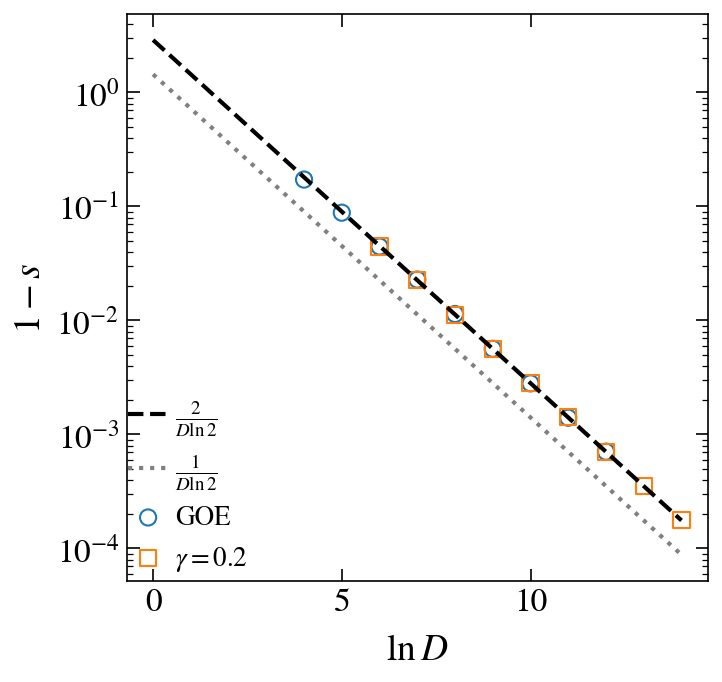

In [285]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1
colors_ls = (list(mcolors.TABLEAU_COLORS)[:500])
colors_ls_cyc = itertools.cycle(colors_ls)
markers = itertools.cycle(['o','s','v', 'D', '*', 'X', '^', '<', '+'])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 150, sharey=True)

sizes = np.arange(4, 15, 1)
dims = 2**(sizes)

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in [0.0, 0.2]:
    mar = next(markers)
    col = next(colors_ls_cyc)
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    axis.scatter(sizes, 1 - S, label='GOE' if g == 0 else r"$\gamma=%g$"%g, marker=mar, color=col, facecolor='None', s=60)

axis.plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$', lw=2)
axis.plot(dense_sizes, 1 / np.log(2) / (2**dense_sizes), ls=':', c='gray', label=r'$\frac{1}{D\ln{2}}$', lw=2)


fig_help.set_plot_elements(axis, xlabel=r"$\ln{D}$", ylabel=r"$1-s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis, loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

## DEGENERACY MIXING

[2 3 4 4 4 5]
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=8,J=1.hdf5
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=12,J=1.hdf5
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=16,J=1.hdf5
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=20,J=1.hdf5
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=24,J=1.hdf5
../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/E=0,Q=0/_L=28,J=1.hdf5
[0.25 0.5  0.75 2.  ]


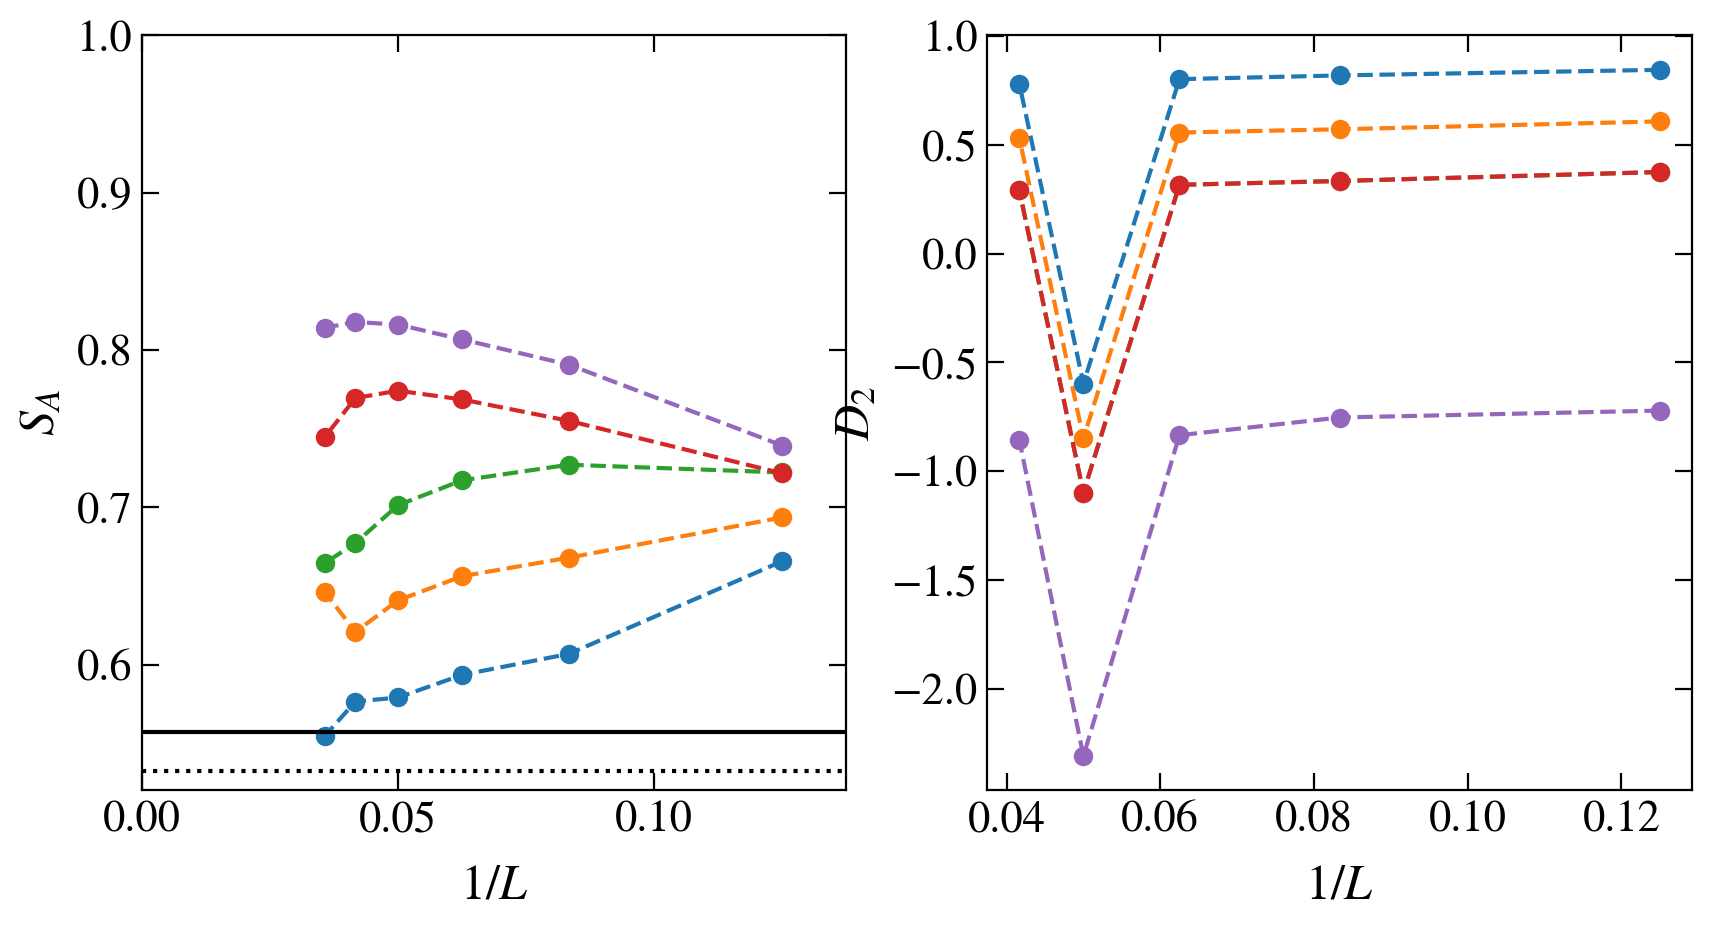

In [2]:
L = 20
w = 2
J = 1
op=0

DIM = 1
modello = 'FreeFermions'

prefix = base_dir(model=modello, d=DIM) + 'Entropy/Degeneracy/'
if op == 0:     prefix += "E=0,Q=0/"
elif op == 2:   prefix += "AllStates/"
else:           prefix += "RandomChoice/"

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

sizes = np.arange(8, 29, 4)

print( (sizes**0.5).astype(int) )

S = []
pr = []
qs = None
for L in sizes:
    name = prefix + info(L=L, J=J, w=w, model = modello, ext='.hdf5')
    print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S.append(np.array(file.get('entropy')) / (L//2 * np.log(2)))
            
            pr.append( np.array(file.get('participation_ratio'))[-1])
            qs = np.array(file.get('qs'))
            # print(np.array(file.get('participation_ratio'))[-1].shape, qs.shape)
            
S = np.transpose(np.array(S))
pr = np.transpose(np.array(pr))
print(qs)

# def plot_and_fit(y, label):
#     axis[0].scatter(1/sizes, y, label=label)
    

axis[0].plot(1/sizes, S[0], label=r'$\Gamma=1$',    ls='--', marker='o')
axis[0].plot(1/sizes, S[1], label=r'$\Gamma=2$',    ls='--', marker='o')
axis[0].plot(1/sizes, S[2], label=r'$\Gamma=4$',    ls='--', marker='o')
axis[0].plot(1/sizes, S[-2], label=r'$\Gamma=L/2$', ls='--', marker='o')
axis[0].plot(1/sizes, S[-1], label=r'$\Gamma=L$',   ls='--', marker='o')

def fract_dim(pr, idx):
    return np.diff(pr[idx]) / np.log(2) / (qs[idx] - 1)

# print( np.diff(pr[0] ) / np.log(2))
axis[1].plot(1/sizes[:-1], np.diff( np.log2(pr[0] ) ) / np.diff((sizes))  , ls='--', marker='o')
axis[1].plot(1/sizes[:-1], np.diff( np.log2(pr[1] ) ) / np.diff((sizes))  , ls='--', marker='o')
axis[1].plot(1/sizes[:-1], np.diff( np.log2(pr[2] ) ) / np.diff((sizes))  , ls='--', marker='o')
axis[1].plot(1/sizes[:-1], np.diff( np.log2(pr[-2]) ) / np.diff((sizes))  , ls='--', marker='o')
axis[1].plot(1/sizes[:-1], np.diff( np.log2(pr[-1]) ) / np.diff((sizes))  , ls='--', marker='o')

axis[0].axhline(y=gaussian(0.5), ls='-', c='k')
axis[0].axhline(y=freefermions([0.5]), ls=':', c='k')

fig_help.set_plot_elements(axis[0], xlabel=r"$1/L$", ylabel=r"$S_A$", font_size=16, set_legend=False, xscale='linear', yscale='linear', xlim=(0, 1.1/8), ylim=(0.52, 1))
fig_help.set_plot_elements(axis[1], xlabel=r"$1/L$", ylabel=r"$D_2$", font_size=16, set_legend=False, xscale='linear', yscale='linear')

## SINGLE-SITE ENTROPY

../results/SYK2/Entropy/ManyBody/_L=13,J=1_jobid=0.hdf5
../results/SYK2/Entropy/ManyBody/_L=14,J=1_jobid=0.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=0.2.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=0.2.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=0.7.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=0.7.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=1.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=1.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=1.5.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=1.5.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=2.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=2.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=2.5.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=2.5.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.5.hdf5
../results/RP/Entropy/ManyBody/_L=14,J=1,g=2.5.hdf5
../results/RP/Entropy/ManyBody/_L=4,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_L=5,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_

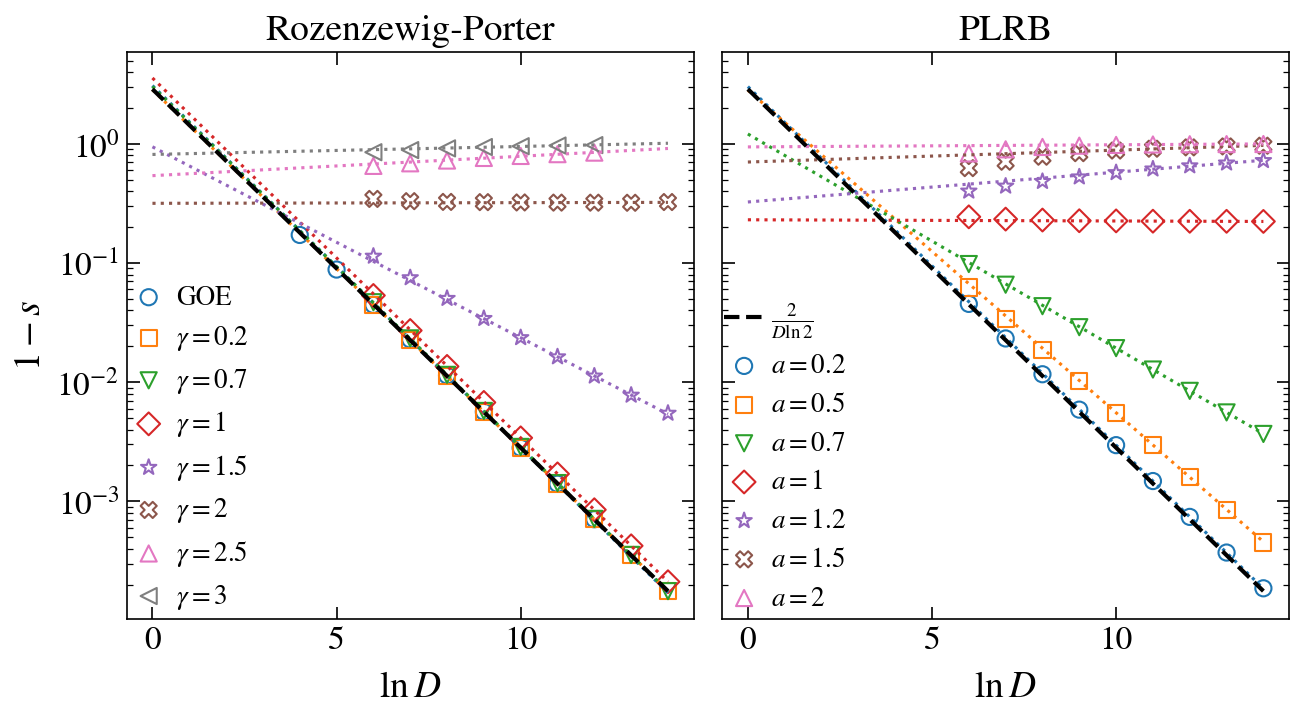

In [282]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1
colors_ls = (list(mcolors.TABLEAU_COLORS)[:500])
colors_ls_cyc = itertools.cycle(colors_ls)
markers = itertools.cycle(['o','s','v', 'D', '*', 'X', '^', '<', '+'])

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(4, 15, 1)
dims = 2**(sizes)

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in [0.0, 0.2, 0.7, 1, 1.5, 2, 2.5, 3]:
    mar = next(markers)
    col = next(colors_ls_cyc)
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    axis[0].scatter(sizes, 1 - S, label='GOE' if g == 0 else r"$\gamma=%g$"%g, marker=mar, color=col, facecolor='None', s=60)
    
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[-5:],
                        ydata = 1-S[-5:],
                        full_output=True, maxfev=10000)
    # print(J, alfa, fit_info['fvec'])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[0].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')
    # if g >= 1:
    #     c = (1 - S[0])
    #     y = 1 / (2**( (2-g) * (sizes)))
    #     y = y/y[0] * c
    #     axis.plot(sizes, y, ls=':', c=col)
colors_ls_cyc = itertools.cycle(colors_ls)
markers = itertools.cycle(['o','s','v', 'D', '*', 'X', '^', '<', '+'])
for g in [0.2, 0.5, 0.7, 1, 1.2, 1.5, 2]:
    mar = next(markers)
    col = next(colors_ls_cyc)
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
    axis[1].scatter(sizes, 1 - S, label='GOE' if g == 0 else r"$a=%g$"%g, marker=mar, color=col, facecolor='None', s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[-5:],
                        ydata = 1-S[-5:],
                        full_output=True, maxfev=10000)
    print(g, "c = ", pars[0], "eta = ", pars[1])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[1].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')           

for ii, ax in enumerate(axis):
    # ax.plot(dense_sizes, 1 / np.log(2) / (2**dense_sizes), ls='--', c='k',   label=r'$\frac{1}{D\ln{2}}$' if ii == 0 else "", lw=2)
    ax.plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$' if ii == 1 else "", lw=2)

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$\ln{D}$", ylabel=r"$1-s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))
fig_help.set_plot_elements(axis[1], xlabel=r"$\ln{D}$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

RP: 15852890.749351783 0.678636191834132
PLRB: 686872097.8252543 0.7757388675621517


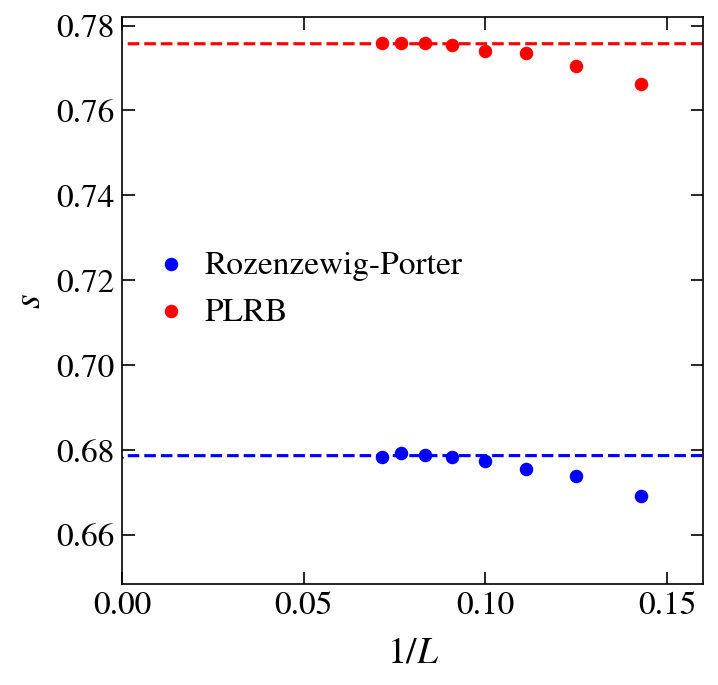

In [13]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 150, sharey=True)

sizes = np.arange(6, 15, 1)
dims = 2**(sizes)
g_vals = np.arange(0.1, 4.1, 0.1)


norm = matplotlib.colors.Normalize(
    vmin=np.min(sizes),
    vmax=np.max(sizes))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

g = 2
nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

S = np.zeros(sizes.shape); S.fill(np.nan)
modello = 'RP'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
for jj, L in enumerate(sizes):
    name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('.hdf5') )
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            if g > 0:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[jj] = np.mean(ent[my_min : my_max]) / np.log(2)
            else:
                S[jj] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
    else:
        print(name)
axis.scatter( 1/sizes, S, s=30, color = 'blue', label = r"Rozenzewig-Porter")

pars, pconv, fit_info, msg, _ = fit(lin_fit,
                    xdata = sizes[-4:],
                    ydata = S[-4:],
                    full_output=True, maxfev=10000)
print("RP:", *pars)
xx = np.linspace(min(sizes), 10000, 10000)
axis.plot( 1/xx, lin_fit(xx, *pars), ls='--',  color = 'blue')

modello = 'PLRB'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
S = np.zeros(sizes.shape); S.fill(np.nan)
g = 1
for jj, L in enumerate(sizes):
    name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            E = np.array(file.get('mean energies'))
            dim = E.size
            ent = np.array(file.get('single_site_entropy'))[0]
            
            num = frac(dim)
            if nu > 1:
                num = min([num, int(0.1*dim)])
            # print(dim, num)
            E_av = np.mean(E)
            index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
            
            my_min = int(index_meanE - num / 2)
            if num == dim or my_min < 0: my_min = 0;  

            my_max = int(index_meanE + num / 2)
            if num == dim or my_max >= dim: my_max = dim-1
            S[jj] = np.mean(ent[my_min : my_max]) / np.log(2)
    else:
        print(name)
        
axis.scatter( 1 / sizes, S, s=30, color='red', label = r"PLRB")             

pars, pconv, fit_info, msg, _ = fit(lin_fit,
                    xdata = sizes[-4:],
                    ydata = S[-4:],
                    full_output=True, maxfev=10000)
print("PLRB:", *pars)
xx = np.linspace(min(sizes), 10000, 10000)
axis.plot( 1/xx, lin_fit(xx, *pars), ls='--',  color = 'red')
axis.set_xlim(0, 0.16)

fig_help.set_plot_elements(axis, xlabel=r"$1/L$", ylabel=r"$s$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
fig_help.set_legend(axis, loc = 'lower left', fontsize=16, anchor=(-0.01, 0.4))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

### RAW DATA + COLLAPSE

../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.2.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.3.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.4.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.5.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.6.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.7.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.8.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=2.9.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.1.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.2.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.3.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.4.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.5.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.6.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.7.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.8.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=3.9.hdf5
../results/RP/Entropy/ManyBody/_L=13,J=1,g=4.hdf5
../results/RP/En

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


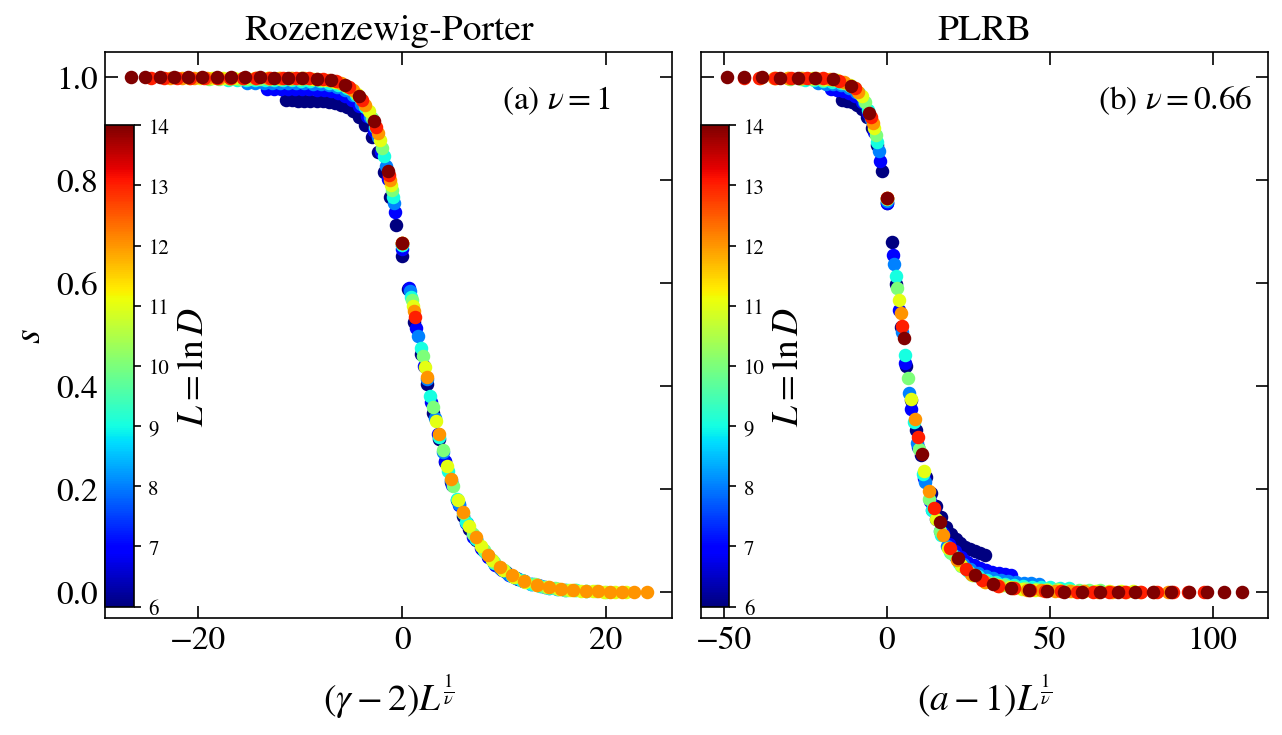

In [280]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(6, 15, 1)
dims = 2**(sizes)
g_vals = np.arange(0.1, 4.1, 0.1)


norm = matplotlib.colors.Normalize(
    vmin=np.min(sizes),
    vmax=np.max(sizes))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for jj, L in enumerate(sizes):
    col = s_m.to_rgba(L)
    modello = 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(g_vals.shape); S.fill(np.nan)
    for ii, g in enumerate(g_vals):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    axis[0].scatter( (g_vals-2) * L, S, color=col, s=30)

cbaxes = axis[0].inset_axes([0.0, 0.02, 0.05, 0.85])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='vertical')
cbar.set_label(r"$L=\ln{D}$", fontsize=18)
# cbaxes.xaxis.set_ticks_position('top')
# cbaxes.xaxis.set_label_position('top')
    
g_vals = np.arange(0.1, 3.1, 0.1)

norm = matplotlib.colors.Normalize(
    vmin=np.min(sizes),
    vmax=np.max(sizes))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])
for jj, L in enumerate(sizes):
    col = s_m.to_rgba(L)
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(g_vals.shape); S.fill(np.nan)
    for ii, g in enumerate(g_vals):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
            
    nu = 0.66
    axis[1].scatter( (g_vals-1) * L**(1/nu), S, color=col, s=30)             

cbaxes = axis[1].inset_axes([0.0, 0.02, 0.05, 0.85])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='vertical')
cbar.set_label(r"$L=\ln{D}$", fontsize=18)

axis[0].annotate(r"(a) $\nu=1$",     fontsize=16, xy=(0.7, 0.9), xycoords='axes fraction')
axis[1].annotate(r"(b) $\nu=%g$"%nu, fontsize=16, xy=(0.7, 0.9), xycoords='axes fraction')

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$(\gamma-2)L^{\frac{1}{\nu}}$", ylabel=r"$s$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))
fig_help.set_plot_elements(axis[1], xlabel=r"$(a-1)L^{\frac{1}{\nu}}$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='linear')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

### FITTING and FADING

../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.1.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.2.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.4.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.5.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.6.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.7.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.8.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.9.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.1.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.2.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.4.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.5.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.6.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.7.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.8.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.9.hdf5
../results/PLR

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.4.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.5.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.6.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.7.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.8.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.9.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=3.hdf5


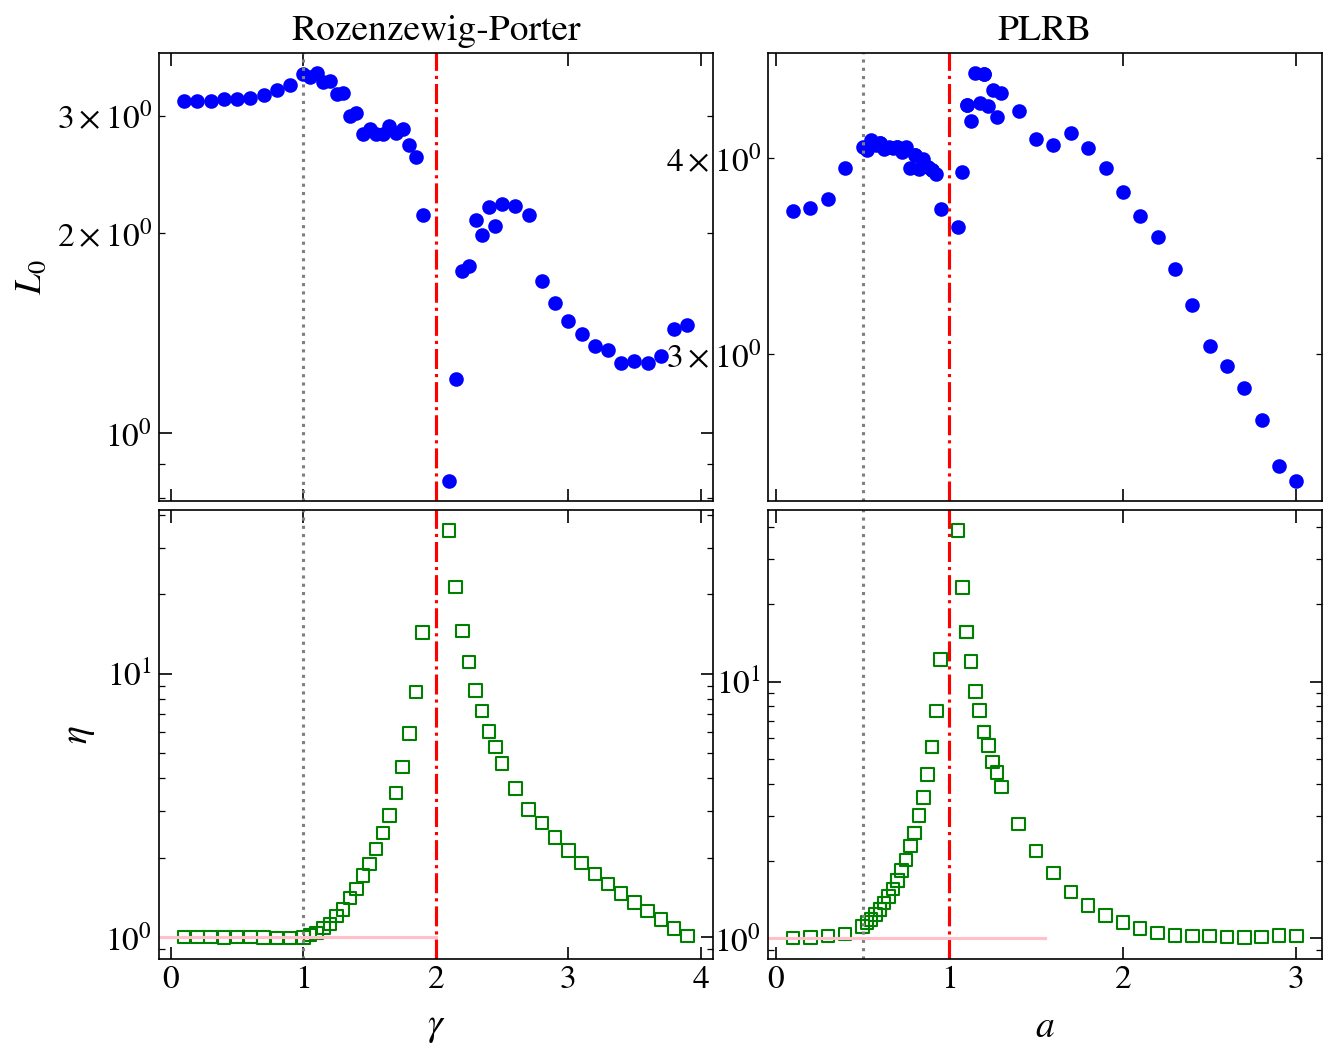

In [14]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1
colors_ls = (list(mcolors.TABLEAU_COLORS)[:500])
colors_ls_cyc = itertools.cycle(colors_ls)
markers = itertools.cycle(['o','s','v', 'D', '*', 'X', '^', '<', '+'])

fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 150, sharex = 'col')
axis = axes[0, :]
ax = axes[1, :]

g_vals = np.arange(0.1, 4.0, 0.1)
g_vals2 = np.arange(1.05, 2.5, 0.1)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))

sizes = np.arange(6, 16, 1)
dims = 2**(sizes)

sc = 0.678636191834132
def _fit1(L, L0, eta):
    return 1 - (1-sc) * 2**(-(L - L0) / eta)

def _fit2(L, L0, xi):
    return (sc) * 2**(-(L - L0) / xi)

prefactor = []
etas = []
nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in g_vals:
    if np.abs(g - 2) <= 0.06:
        prefactor.append(np.nan)
        etas.append(np.nan)
        continue
    entropy_fit = _fit1 if g <= 2 else _fit2
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[-6:],
                        ydata = S[-6:],
                        full_output=True, maxfev=10000)
    prefactor.append(pars[0])
    etas.append(np.abs(pars[1]) )
axis[0].scatter(g_vals, prefactor, color='blue')
axis[0].axvline(x=1, ls=':', color='gray')
axis[0].axvline(x=2, ls='-.', color='r')
ax[0].axvline(x=1, ls=':', color='gray')
ax[0].axvline(x=2, ls='-.', color='r')
ax[0].scatter(g_vals, etas, marker = 's', color='green', facecolor='None')

x = np.linspace(1, 2, 1000)
# ax[0].plot(x, 1/np.abs(x - 2), ls='-', color='orange', lw=5, alpha=0.3)

sc = 0.7757388675621517
def _fit1(L, L0, eta):
    return 1 - (1 - sc) * 2**(-(L - L0) / eta)

def _fit2(L, L0, xi):
    return (sc) * 2**(-(L - L0) / xi)
prefactor = []
etas = []
g_vals = np.arange(0.1, 3.1, 0.1)
g_vals2 = np.arange(0.525, 1.3, 0.025)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))

for g in g_vals:
    if np.abs(g - 1) <= 0.03: 
        prefactor.append(np.nan)
        etas.append(np.nan)
        continue
    entropy_fit = _fit1 if g <= 1 else _fit2
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[-6:],
                        ydata = S[-6:],
                        full_output=True, maxfev=10000)
    prefactor.append(pars[0])
    etas.append(np.abs(pars[1]) )
axis[1].scatter(g_vals, prefactor, color='blue')
axis[1].axvline(x=0.5, ls=':', color='gray')
axis[1].axvline(x=1, ls='-.', color='r')
ax[1].axvline(x=0.5, ls=':', color='gray')
ax[1].axvline(x=1, ls='-.', color='r')
ax[1].scatter(g_vals, etas, marker = 's', color='green', facecolor='None')

x = np.linspace(0.5, 3, 1000)
# ax[1].plot(x, 0.5/np.abs(x - 1), ls='-', color='orange', lw=5, alpha=0.3)

ax[0].axhline(y=1, ls='-', c='pink', xmax=0.5)
ax[1].axhline(y=1, ls='-', c='pink', xmax=0.5)

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$\gamma$", ylabel=r"$L_0$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_plot_elements(ax[0], xlabel=r"$\gamma$", ylabel=r"$\eta$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig_help.set_plot_elements(axis[1], xlabel=r"$a$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_plot_elements(ax[1], xlabel=r"$a$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))


# for ax in axis:
#     ax.axhline(y=2/np.log(2), ls='--', c='k', xmax=0.5)
    
fig.subplots_adjust(wspace = 0.1, hspace=0.02)

#### ERGODIC SIDE

0.1 c =  2.7252038539418013 eta =  0.6862896456643987
0.2 c =  2.8265608261442092 eta =  0.6863805226670093
0.30000000000000004 c =  2.8664924503822284 eta =  0.6786832100072211
0.4 c =  2.738183509565412 eta =  0.6545243291756294
0.5 c =  2.477908114176726 eta =  0.6105654768378012
0.525 c =  2.4203699546260657 eta =  0.5969706113470549
0.55 c =  2.2558288134088067 eta =  0.5772123935426555
0.5750000000000001 c =  2.120249503950569 eta =  0.5571923496927004
0.6 c =  1.8611162309798015 eta =  0.5292461186548477
0.6000000000000001 c =  1.8611162309798015 eta =  0.5292461186548477
0.6250000000000001 c =  1.7511578559923393 eta =  0.5066468297366367
0.6500000000000001 c =  1.55476602160007 eta =  0.4773567166396228
0.6750000000000002 c =  1.3512784310482449 eta =  0.4444362528005995
0.7000000000000001 c =  1.1404271527037568 eta =  0.4083745175905028
0.7000000000000002 c =  1.1404271527037568 eta =  0.4083745175905028
0.7250000000000002 c =  1.0131208048855855 eta =  0.3758828991000944
0.

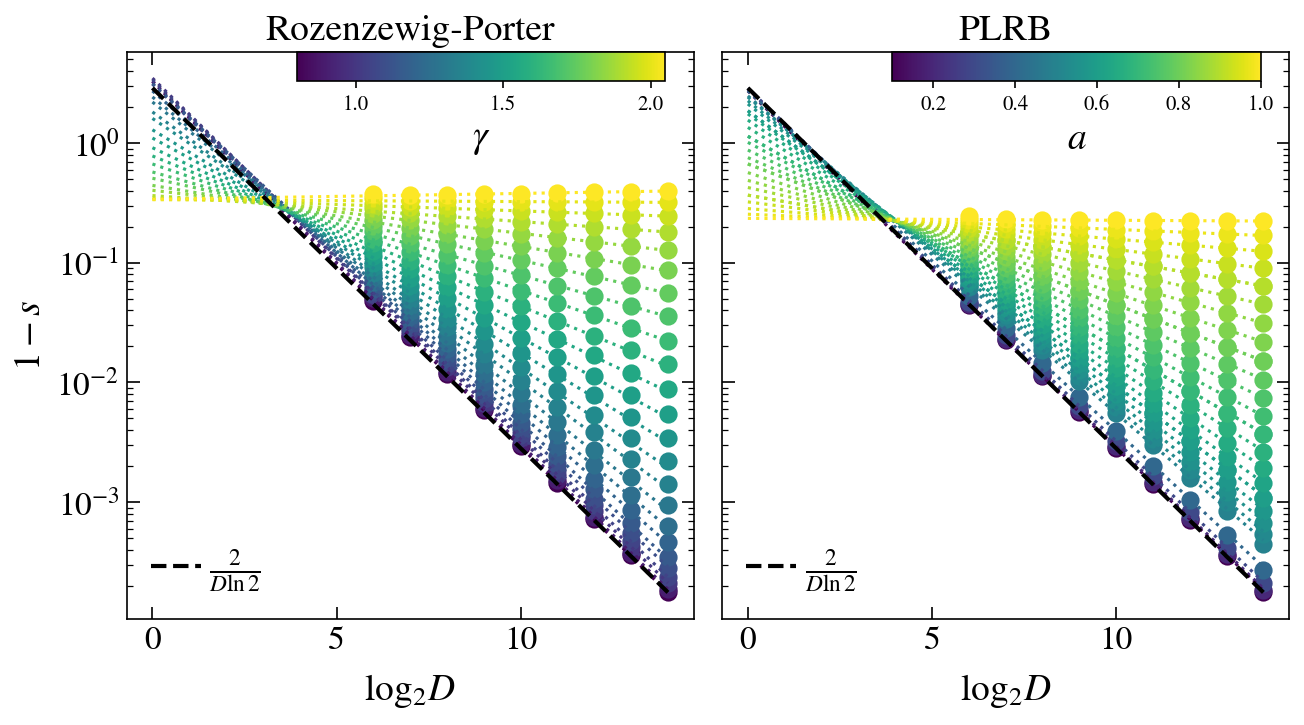

In [27]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(6, 15, 1)
dims = 2**(sizes)
g_vals = np.arange(0.8, 2.1, 0.1)
g_vals2 = np.arange(1.05, 2.1, 0.1)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))


norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in g_vals:
    col = s_m.to_rgba(g)
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    axis[0].scatter(xx, 1 - S, color=col, s=60)
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[1:],
                        ydata = 1-S[1:],
                        full_output=True, maxfev=10000)
    # print(J, alfa, fit_info['fvec'])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[0].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')
    # if g >= 1:
    #     c = (1 - S[0])
    #     y = 1 / (2**( (2-g) * (sizes)))
    #     y = y/y[0] * c
    #     axis.plot(sizes, y, ls=':', c=col)

cbaxes = axis[0].inset_axes([0.3, 0.95, 0.65, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$\gamma$", fontsize=18)
    
g_vals = np.arange(0.1, 1.1, 0.1)
g_vals2 = np.arange(0.525, 1.0, 0.025)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))

norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])
for g in g_vals:
    col = s_m.to_rgba(g)
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]    
    axis[1].scatter(xx, 1 - S, color=col, s=60)     
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = 1-S[2:],
                        full_output=True, maxfev=10000)
    print(g, "c = ", pars[0], "eta = ", pars[1])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[1].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')           

cbaxes = axis[1].inset_axes([0.3, 0.95, 0.65, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$a$", fontsize=18)

for ii, ax in enumerate(axis):
    # ax.plot(dense_sizes, 1 / np.log(2) / (2**dense_sizes), ls='--', c='k',   label=r'$\frac{1}{D\ln{2}}$' if ii == 0 else "", lw=2)
    ax.plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$', lw=2)

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$\log_2{D}$", ylabel=r"$1-s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))
fig_help.set_plot_elements(axis[1], xlabel=r"$\log_2{D}$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

#### LOCALISED SIDE

2.0 c =  0.6777396545719437 eta =  713825001.9647641
2.1 c =  0.6836570207157595 eta =  52.38946366609399
2.2 c =  0.7223490518445753 eta =  21.67213476942508
2.3000000000000003 c =  0.7747933725235095 eta =  12.897240924724935
2.4000000000000004 c =  0.8330634625870958 eta =  8.973129072163395
2.5000000000000004 c =  0.8916072118093443 eta =  6.813147671587837
2.6000000000000005 c =  0.9520832210653387 eta =  5.4573803848195475
2.7000000000000006 c =  1.0093093316208595 eta =  4.546971929688681
../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.8.hdf5
2.8000000000000007 c =  1.0479394168957992 eta =  3.9154542089255413
../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.9.hdf5
2.900000000000001 c =  1.0960442323730648 eta =  3.4181246898677227
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.hdf5
3.000000000000001 c =  1.1499099675143 eta =  3.0277003163601988
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.1.hdf5
3.100000000000001 c =  1.209158225641886 eta =  2.7131232269682277
../results/RP/Entropy/Ma

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


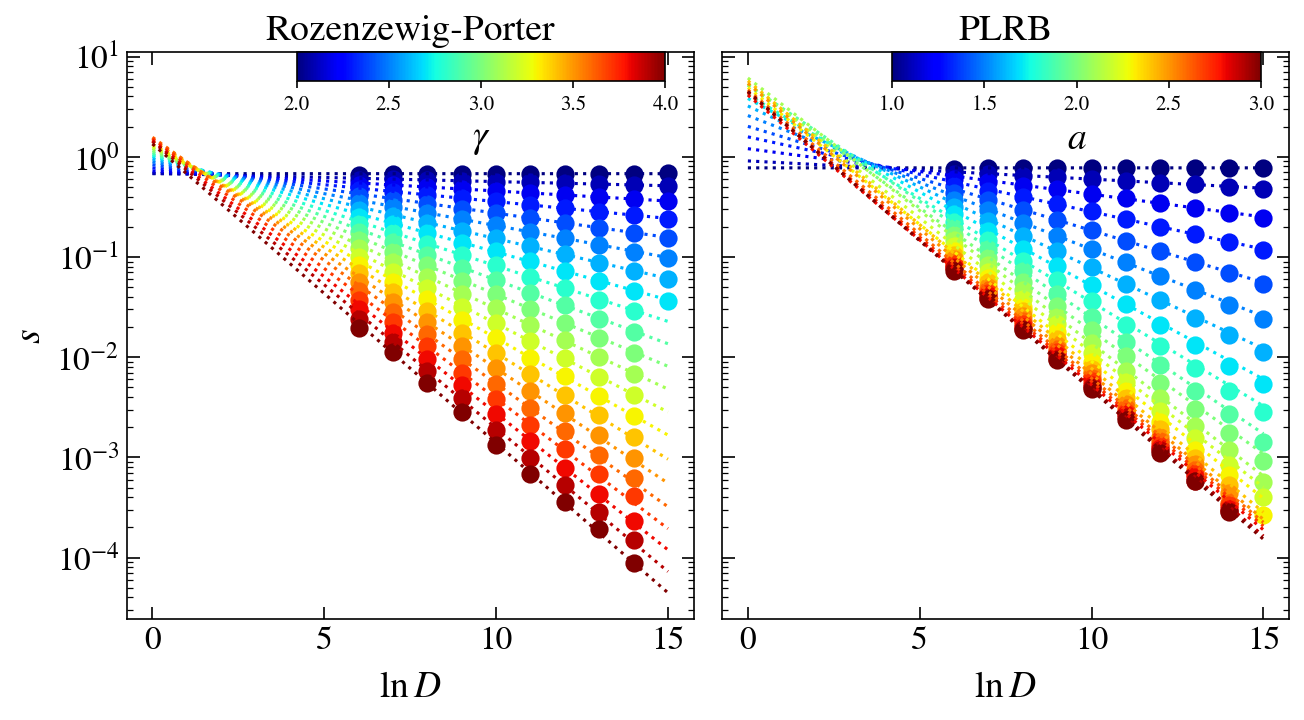

In [15]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(6, 16, 1)
dims = 2**(sizes)
g_vals = np.arange(2.0, 4.1, 0.1)


norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])

def entropy_fit(L, c, xi):
    return c * np.exp(-L / xi)

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in g_vals:
    col = s_m.to_rgba(g)
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    axis[0].scatter(sizes, S, color=col, s=60)
    
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = S[2:],
                        full_output=True, maxfev=10000)
    # print(J, alfa, fit_info['fvec'])
    print(g, "c = ", pars[0], "eta = ", pars[1])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[0].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')
    # if g >= 1:
    #     c = (1 - S[0])
    #     y = 1 / (2**( (2-g) * (sizes)))
    #     y = y/y[0] * c
    #     axis.plot(sizes, y, ls=':', c=col)

cbaxes = axis[0].inset_axes([0.3, 0.95, 0.65, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$\gamma$", fontsize=18)
    
g_vals = np.arange(1.0, 3.1, 0.1)

norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])
for g in g_vals:
    col = s_m.to_rgba(g)
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
    axis[1].scatter(sizes, S, color=col, s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    S  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = S[2:],
                        full_output=True, maxfev=10000)
    print(g, "c = ", pars[0], "eta = ", pars[1])
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[1].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')           

cbaxes = axis[1].inset_axes([0.3, 0.95, 0.65, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$a$", fontsize=18)

# for ii, ax in enumerate(axis):
#     # ax.plot(dense_sizes, 1 / np.log(2) / (2**dense_sizes), ls='--', c='k',   label=r'$\frac{1}{D\ln{2}}$' if ii == 0 else "", lw=2)
#     ax.plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$', lw=2)

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$\ln{D}$", ylabel=r"$s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))
fig_help.set_plot_elements(axis[1], xlabel=r"$\ln{D}$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig.subplots_adjust(wspace = 0.05, hspace=0.02)

In [19]:
40 * 6 * 16

3840

### BETA FUNCTION

../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.1.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.2.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.4.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.5.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.6.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=0.7.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.3.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.525.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.575.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.625.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.675.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.725.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.775.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.825.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.875.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=1.025.hdf5


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=1.075.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=1.125.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=1.175.hdf5


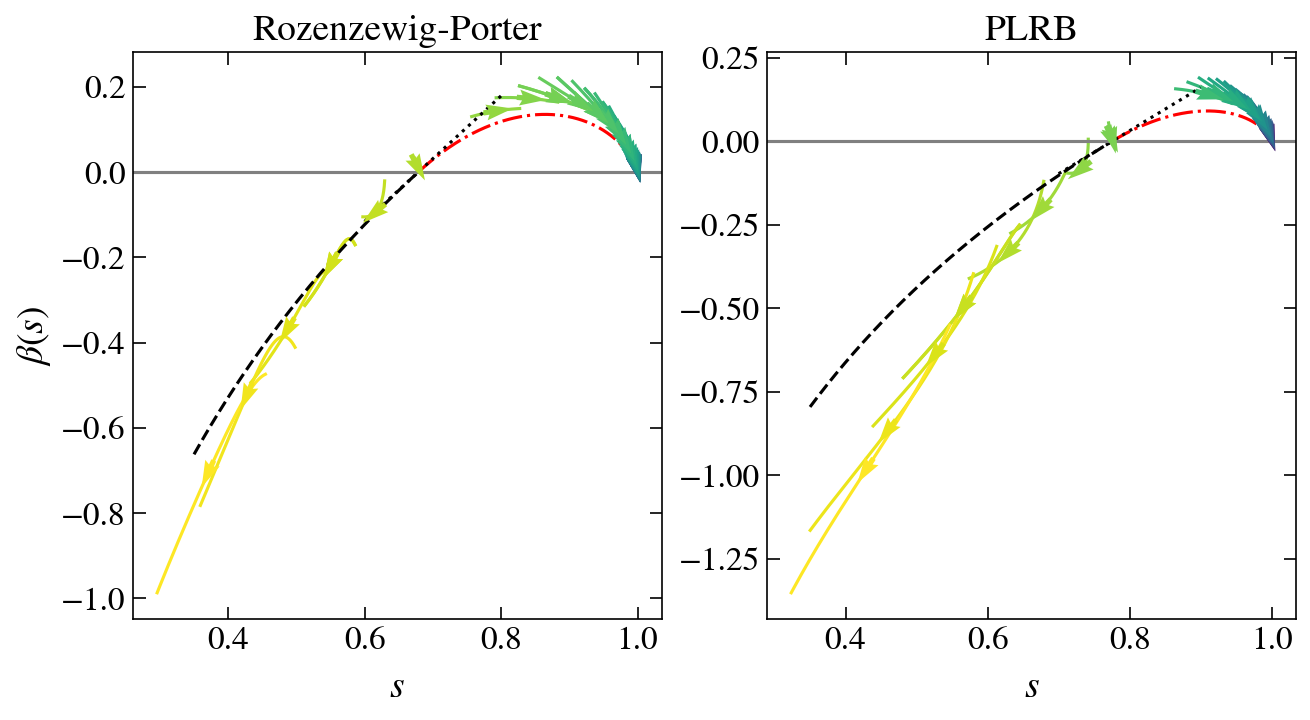

In [16]:
L = 20
w = 2
J = 1
g=0.2
op=0

DIM = 1
colors_ls = (list(mcolors.TABLEAU_COLORS)[:500])
colors_ls_cyc = itertools.cycle(colors_ls)
markers = itertools.cycle(['o','s','v', 'D', '*', 'X', '^', '<', '+'])

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharex = 'col')


def beta_function(xx, yy):
    return diff_central(np.log(xx), np.log(yy))

g_vals = np.arange(0.1, 2.2, 0.1)
g_vals2 = np.arange(1.05, 1.9, 0.05)
g_vals3 = np.arange(2.0, 2.3, 0.05)
g_vals = np.unique( np.array([*g_vals, *g_vals2, *g_vals3]))

sizes = np.arange(8, 16, 1)
dims = 2**(sizes)

use_fit = 1


def _fit1(L, c, eta):
    return 1 - c * 2**(-L / eta)

def _fit2(L, c, xi):
    return c * np.exp(-L / xi)

def pade_fun(x, c0, c1, d0, d1):
    # return (x**2 + c1 * x + c0) / (x**2 + d1 * x + d0)
    return (x**2 + c1 * x + c0) / (x**2 + d1 * x + d0)

def loc_fit(x, c0, c1, c2, c3):
    return c3 / x**3 + c2 / x**2 + c1 / x + c0


norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

yax_min = 1e6
yax_max = -1e6
nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

L0 = 0
sc = 0.678636191834132
for g in g_vals:
    col = s_m.to_rgba(g)
    # entropy_fit = _fit1 if g < 2 else _fit2
    entropy_fit = pade_fun if g <= 2 else loc_fit
    modello = 'SYK2' if g == 0 else 'RP'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
    
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices] - L0
    yy  = S[indices]         
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx,
                        ydata = yy,
                        full_output=True, maxfev=10000)
    # print(J, alfa, fit_info['fvec'])
    if use_fit:
        xx = np.linspace(xx[0], xx[-1], 1000)
        yy = entropy_fit(xx, *pars)
        beta = beta_function( (xx), (yy))# * xx[1:-1] / yy[1:-1]
        xx_beta = yy[1:-1]
    else:
        beta = beta_function( (xx), (yy))# * xx[1:-1] / yy[1:-1]
        xx_beta = yy[1:-1]

    line, = axis[0].plot(xx_beta, beta, marker='o', markersize=0 if use_fit else 2, lw=1.5, color=col)
    
    if min(beta) < yax_min: yax_min = min(beta)
    if max(beta) > yax_max: yax_max = max(beta)
    
    i1 = xx_beta.size // 2 - 1
    dx = xx_beta[i1+1] - xx_beta[i1]
    dy = beta[i1+1] - beta[i1]
    pos_x = xx_beta[i1] + dx/2
    pos_y = beta[i1] + dy/2
    arr_norm = np.sqrt(dx**2 + dy**2)
    # axis[0].arrow(pos_x, pos_y, 0.01 * dx, 0.01 * dy, shape='full', lw=0, length_includes_head=True, head_width=.05, color=col)
    axis[0].quiver(pos_x, pos_y, dx/arr_norm, dy/arr_norm, angles="xy", zorder=5, pivot="mid", color=col, linewidth=0, width=0.01, headwidth=3, lw=0)
x = np.linspace(sc, 1, 1000)
axis[0].plot(x, -(1-x) / x * np.log( (1-x) / (1-sc)), ls='-.', c='red')
x = np.linspace(0.35, sc, 1000)
axis[0].plot(x, np.log( x / sc), ls='--', c='k')
x = np.linspace(0.6, 0.8, 1000)
axis[0].plot(x, (x-sc)/sc, ls=':', color='k')

g_vals = np.arange(0.3, 1.2, 0.1)
g_vals2 = np.arange(0.525, 0.9, 0.025)
g_vals3 = np.arange(1.0, 1.2, 0.025)
g_vals = np.unique( np.array([*g_vals, *g_vals2, *g_vals3]))

norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

yax_min = 1e6
yax_max = -1e6

L0 = 0
sc = 0.7757388675621517
for g in g_vals:
    col = s_m.to_rgba(g)
    # entropy_fit = _fit1 if g < 1 else _fit2
    entropy_fit = pade_fun if g <= 1 else loc_fit
    modello = 'PLRB'
    prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                E = np.array(file.get('mean energies'))
                dim = E.size
                ent = np.array(file.get('single_site_entropy'))[0]
                
                num = frac(dim)
                if nu > 1:
                    num = min([num, int(0.1*dim)])
                # print(dim, num)
                E_av = np.mean(E)
                index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if num == dim or my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2)
                if num == dim or my_max >= dim: my_max = dim-1
                S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
        else:
            print(name)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices] - L0
    yy  = S[indices]          
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx,
                        ydata = yy,
                        full_output=True, maxfev=10000)        
    
    if use_fit:
        xx = np.linspace(xx[0], xx[-1], 1000)
        yy = entropy_fit(xx, *pars)
        beta = beta_function( (xx), (yy))# * xx[1:-1] / yy[1:-1]
        xx_beta = yy[1:-1]
    else:
        beta = beta_function( (xx), (yy))# * xx[1:-1] / yy[1:-1]
        xx_beta = yy[1:-1]

    line, = axis[1].plot(xx_beta, beta, marker='o', markersize=0 if use_fit else 2, lw=1.5, color=col)
    
    if min(beta) < yax_min: yax_min = min(beta)
    if max(beta) > yax_max: yax_max = max(beta)
    
    i1 = xx_beta.size // 2 - 1
    dx = xx_beta[i1+1] - xx_beta[i1]
    dy = beta[i1+1] - beta[i1]
    pos_x = xx_beta[i1] + dx/2
    pos_y = beta[i1] + dy/2
    arr_norm = np.sqrt(dx**2 + dy**2)
    
    # axis[1].arrow(pos_x, pos_y, 0.01 * dx, 0.01 * dy, shape='full', lw=0, length_includes_head=True, head_width=.05, color=col)
    axis[1].quiver(pos_x, pos_y, dx/arr_norm, dy/arr_norm, angles="xy", zorder=5, pivot="mid", color=col, linewidth=0, width=0.01, headwidth=3, lw=0)
    
# axis[1].scatter(g_vals, prefactor, color='blue')
# axis[1].axvline(x=0.5, ls=':', color='gray')
# axis[1].axvline(x=1, ls='-.', color='r')
# ax[1].axvline(x=0.5, ls=':', color='gray')
# ax[1].axvline(x=1, ls='-.', color='r')
# ax[1].scatter(g_vals, etas, marker = 's', color='green', facecolor='None')

x = np.linspace(sc, 1, 1000)
axis[1].plot(x, -(1-x) / x * np.log( (1-x) / (1-sc)), ls='-.', c='red')
x = np.linspace(0.35, sc, 1000)
axis[1].plot(x, np.log( x / sc), ls='--', c='k')
x = np.linspace(0.7, 0.9, 1000)
axis[1].plot(x, (x-sc)/sc, ls=':', color='k')


x = np.linspace(0.0, 1, 1000)
for ax in axis:
    # ax.plot(x, np.log(x), ls=':', c='gray')
    ax.axhline(y=0, ls='-', c='gray')

axis[0].set_title(r"Rozenzewig-Porter", fontsize=18)
axis[1].set_title(r"PLRB", fontsize=18)
fig_help.set_plot_elements(axis[0], xlabel=r"$s$", ylabel=r"$\beta(s)$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig_help.set_plot_elements(axis[1], xlabel=r"$s$", ylabel=r"", font_size=16, set_legend=True, xscale='linear', yscale='linear')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=13, anchor=(-0.04, -0.03))

fig.subplots_adjust(wspace = 0.2, hspace=0.02)

# ROZENZWEIG - PORTER

In [ ]:
# Rozenzwei

[0.0362027  0.06846355 0.09704922 0.12208986 0.14519105 0.16685101
 0.18728802 0.20695546 0.22612321 0.24471725 0.26275132 0.28043691
 0.29775308 0.31469061 0.33144035 0.34810829 0.36456448 0.38082763
 0.39684274 0.41269837 0.42864833 0.44453282 0.46031904 0.47610417
 0.49175156 0.50738754 0.52306413 0.53879436 0.55469032 0.57058696
 0.58651238 0.60244938 0.61846768 0.63482776 0.65128915 0.66789033
 0.68469274 0.70160966 0.71885201 0.73654468 0.75466593 0.77323667
 0.79222976 0.81198612 0.83255391 0.8540399  0.87706884 0.90222564
 0.94407555]


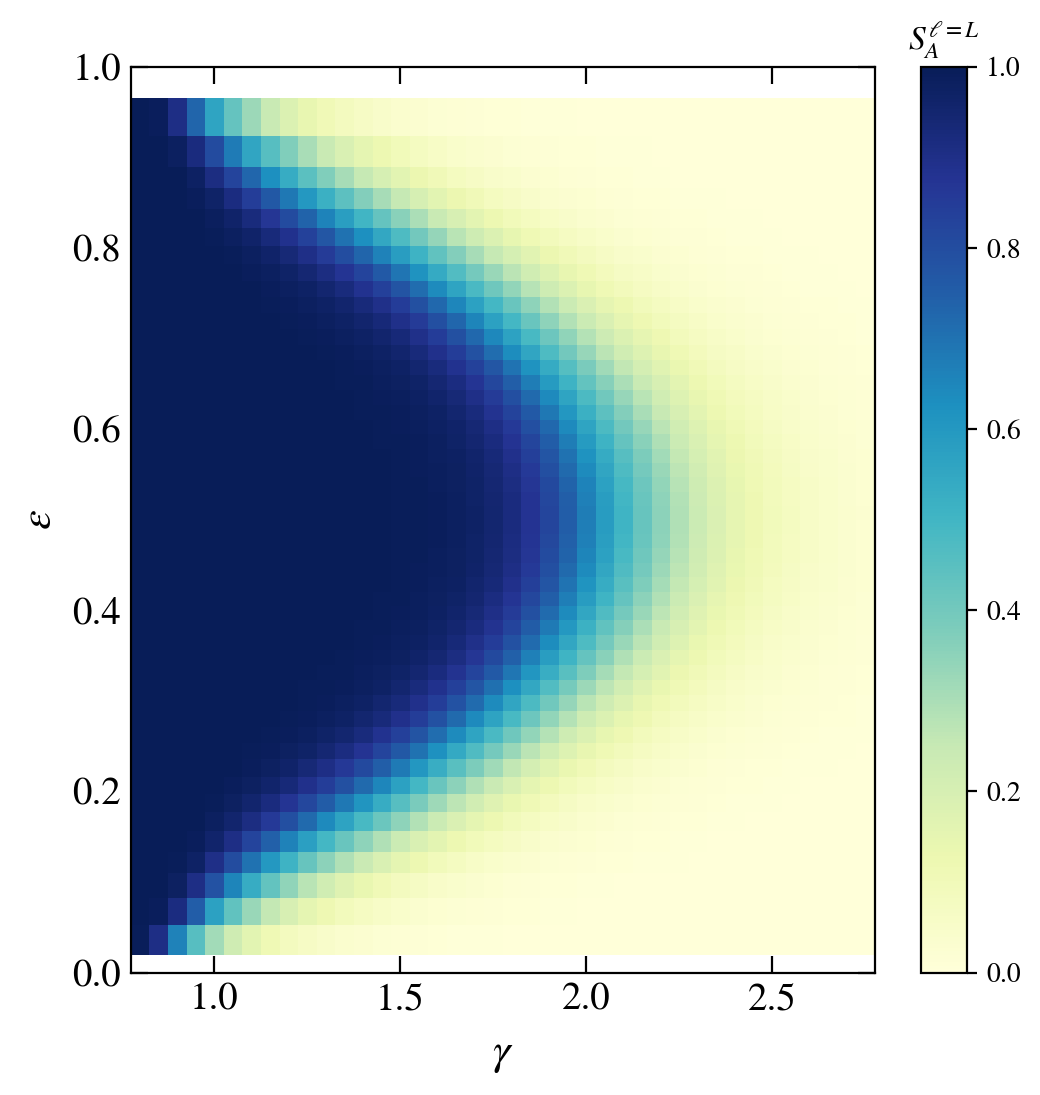

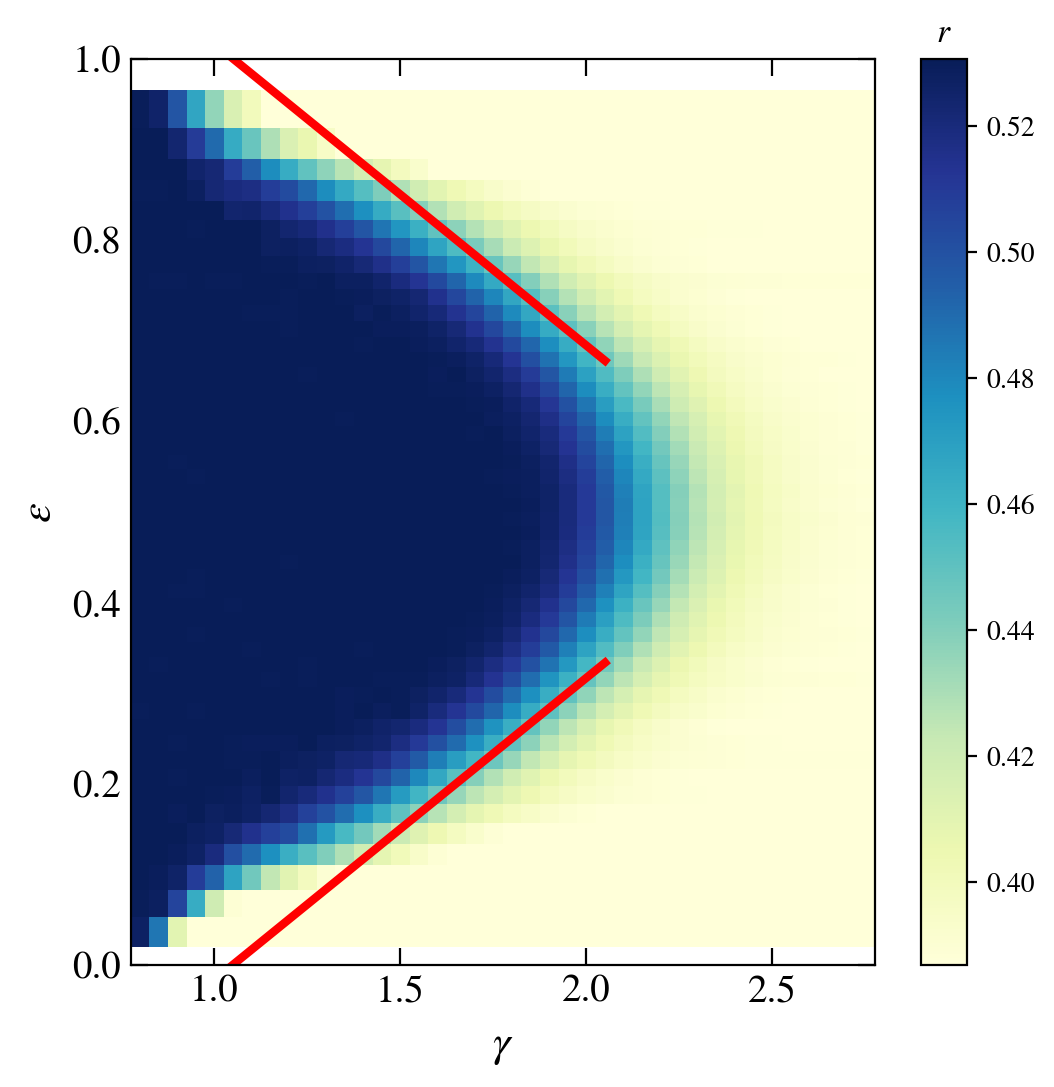

In [17]:


fig1, axis1 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
fig2, axis2 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
axis = [axis1, axis2]

L = 15
w = 2
J = 1
g=0.2
op=0

DIM = 1
modello = 'RP'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'

# fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(4, 15, 1)
dims = 2**(sizes)

g_vals = np.arange(0.8, 2.8, 0.05)
sub_sizes = np.arange(0, L+1)

density = np.zeros((sub_sizes.size, g_vals.size))

ell = 1

energy_density = None
entropy_density = []
gap_ratio_density = []
for ii, g in enumerate(g_vals):
    name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
    if exists(name):
        with h5py.File(name, "r") as file:
            if ii == 0: energy_density = np.array(file.get('energy density'))[:-1]
            S_dens = np.array(file.get('entropy density'))[ell][:-1]
            gap_ratio = np.array(file.get('gap ratio density'))[:-1]
            
            entropy_density.append(S_dens / page(ell, L-ell))
            gap_ratio_density.append(gap_ratio)  
    else:
        print(name)

energy_density = np.array(energy_density)
entropy_density = np.array(entropy_density)

print(energy_density)

interaction = np.array([g_vals for _ in entropy_density[0]])

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# print(g_vals.shape, energy_density.shape, gap_ratio.shape)

X, Y = np.meshgrid(g_vals, energy_density)

p = axis1.pcolormesh(X, Y, np.transpose(entropy_density), shading='nearest', cmap=mymap, vmin=0, vmax=1)
fig_help.set_plot_elements(axis1, ylabel=r"$\epsilon$", xlabel=r"$\gamma$", font_size=14, set_legend=False)
clb = fig1.colorbar(p)
clb.ax.set_title(r"$S^{\ell=L}_A$")

p = axis2.pcolormesh(X, Y, np.transpose(gap_ratio_density), shading='nearest', cmap=mymap, vmin=0.3869, vmax=0.5307)
fig_help.set_plot_elements(axis2, ylabel=r"$\epsilon$", xlabel=r"$\gamma$", font_size=14, set_legend=False)
clb2 = fig2.colorbar(p)
clb2.ax.set_title(r"$r$")

axis1.set_ylim(0,1)
axis2.set_ylim(0,1)
# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())

xx = np.linspace(1, 2, 100)
axis2.plot(xx+0.05, (xx - 1) / 3,   ls='-', c='red', lw=3)
axis2.plot(xx+0.05, 1-(xx - 1) / 3, ls='-', c='red', lw=3)
#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.8.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=2.9.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.1.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.2.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.3.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.4.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.5.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.6.hdf5


No handles with labels found to put in legend.
No handles with labels found to put in legend.


../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.7.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.8.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=3.9.hdf5
../results/RP/Entropy/ManyBody/_L=15,J=1,g=4.hdf5


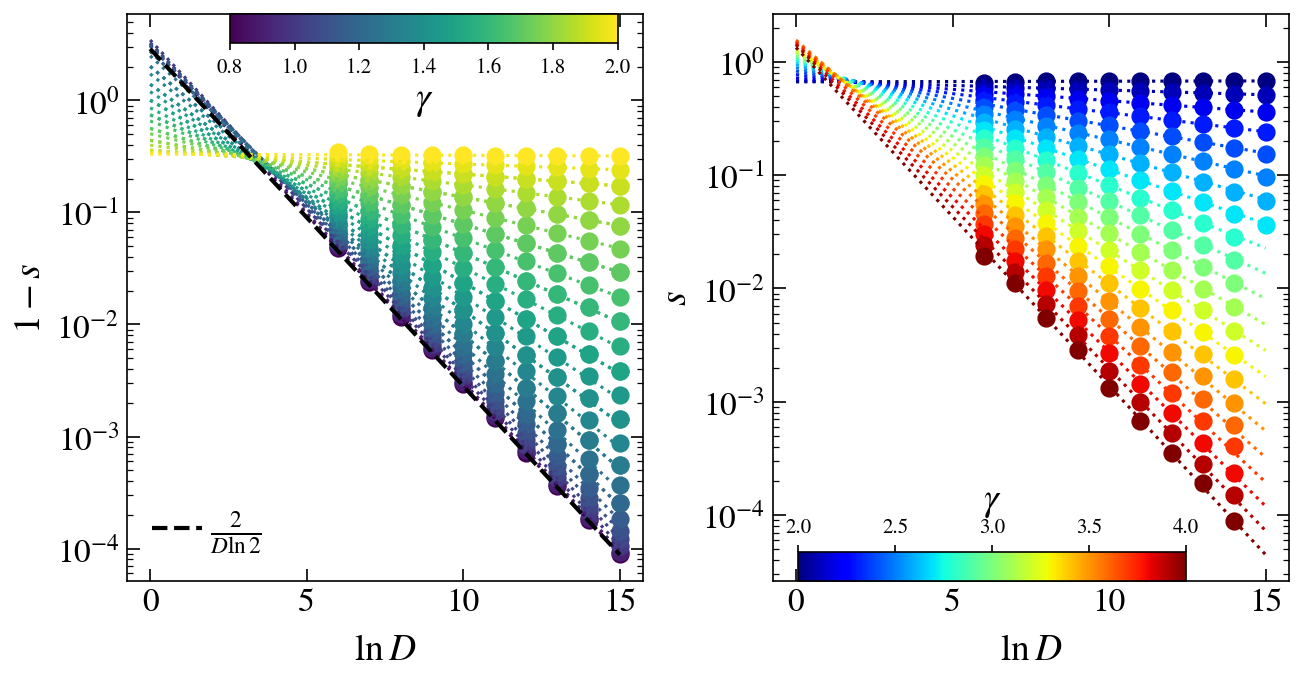

In [28]:
L = 20
w = 2
J = 1
g=0.2
op=0
modello = 'RP'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150)

sizes = np.arange(6, 16, 1)
dims = 2**(sizes)

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)


g_vals = np.arange(0.8, 2.1, 0.1)
g_vals2 = np.arange(1.05, 2.0, 0.05)
# g_vals3 = np.arange(2.0, 2.3, 0.05)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))

norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in g_vals:
    col = s_m.to_rgba(g)
    
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
            
    yy = 1 - S
    axis[0].scatter(sizes, yy, color=col, s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    yy = yy[indices]
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = yy[2:],
                        full_output=True, maxfev=10000)
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[0].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')

cbaxes = axis[0].inset_axes([0.2, 0.95, 0.75, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$\gamma$", fontsize=18)

axis[0].plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$', lw=2)

g_vals = np.arange(2.0, 4.1, 0.1)
norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])
for g in g_vals:
    col = s_m.to_rgba(g)
    
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
            
    yy = S
    axis[1].scatter(sizes, yy, color=col, s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    yy = yy[indices]
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = yy[2:],
                        full_output=True, maxfev=10000)
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[1].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')
cbaxes = axis[1].inset_axes([0.05, 0.0, 0.75, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$\gamma$", fontsize=18)
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')

fig_help.set_plot_elements(axis[0], xlabel=r"$\ln{D}$", ylabel=r"$1-s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))
fig_help.set_plot_elements(axis[1], xlabel=r"$\ln{D}$", ylabel=r"$s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))

fig.subplots_adjust(wspace = 0.25, hspace=0.02)

# POWER-LAW RANDOM BANDED MATRIX

[0.03150559 0.06836518 0.09698776 0.12206266 0.14517204 0.16683749
 0.18727796 0.20694764 0.22611676 0.24471187 0.26274591 0.28043466
 0.29775086 0.31468737 0.33143777 0.34810843 0.36456465 0.38082609
 0.39684142 0.41269774 0.42864841 0.44453244 0.4603197  0.47610428
 0.49175241 0.50738741 0.52306434 0.53879491 0.5546909  0.57058834
 0.58651289 0.60245001 0.61846787 0.63482891 0.65128979 0.66789163
 0.68469448 0.70161137 0.71885481 0.73654881 0.75466981 0.77324162
 0.79223654 0.81199497 0.83256523 0.85405732 0.87709675 0.90228201
 0.94907928]


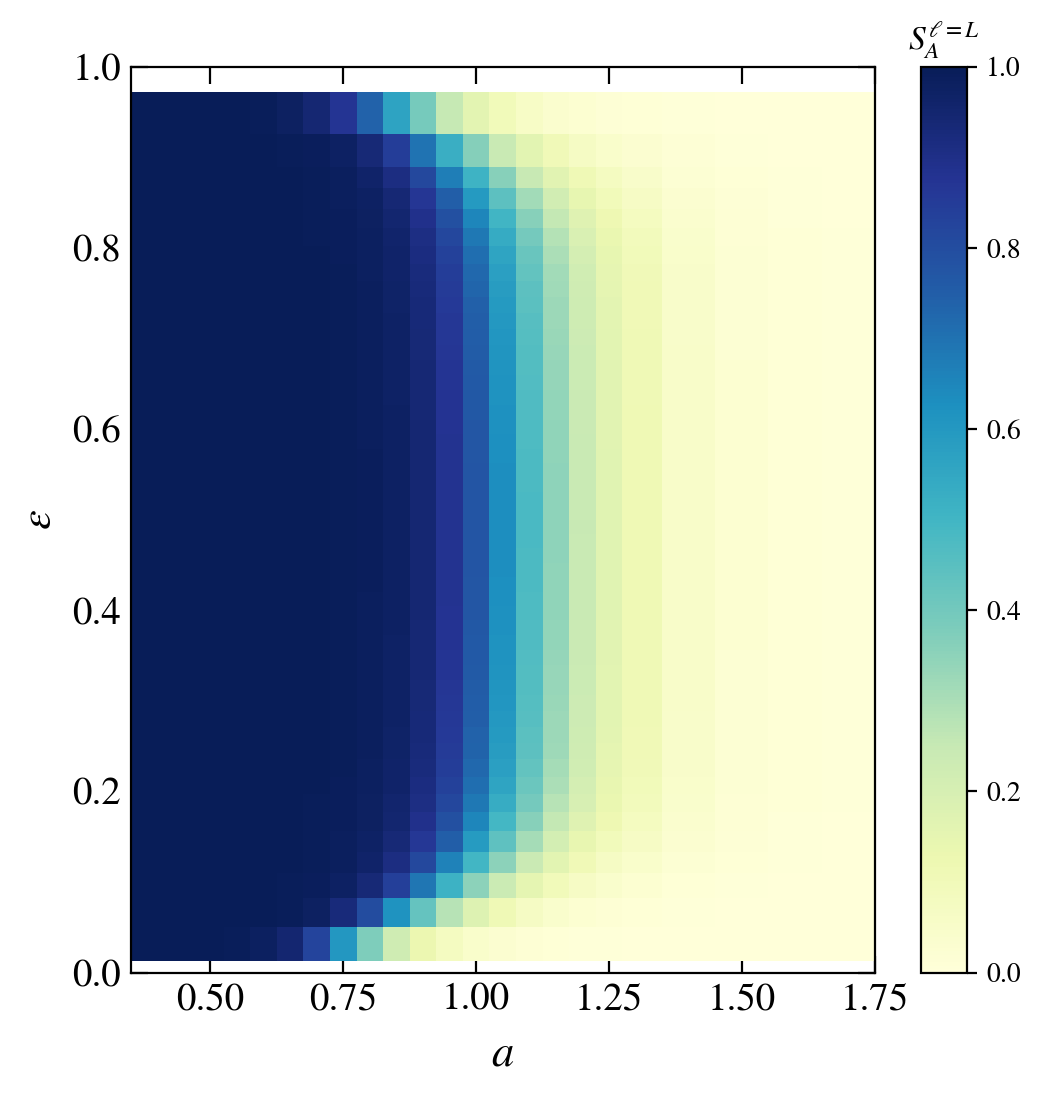

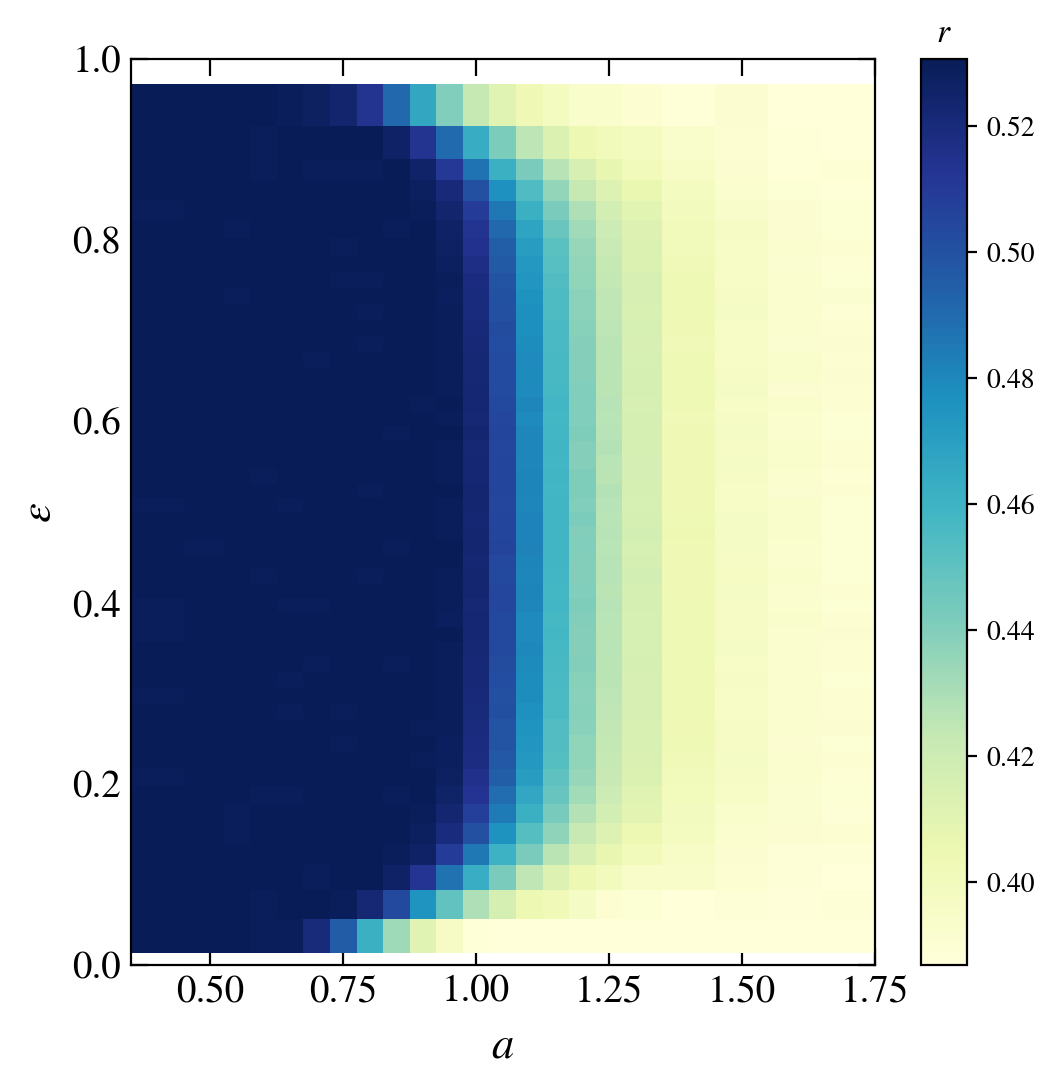

In [36]:


fig1, axis1 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
fig2, axis2 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
axis = [axis1, axis2]

L = 15
w = 2
J = 1
g=0.2
op=0

DIM = 1
modello = 'PLRB'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'

# fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150, sharey=True)

sizes = np.arange(4, 15, 1)
dims = 2**(sizes)

g_vals = np.arange(0.4, 1.8, 0.1)
g_vals2 = np.arange(0.5, 1.3, 0.05)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))
sub_sizes = np.arange(0, L+1)

density = np.zeros((sub_sizes.size, g_vals.size))

ell = 1

energy_density = None
entropy_density = []
gap_ratio_density = []
for ii, g in enumerate(g_vals):
    name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
    if exists(name):
        with h5py.File(name, "r") as file:
            if ii == 0: energy_density = np.array(file.get('energy density'))[:-1]
            S_dens = np.array(file.get('entropy density'))[ell][:-1]
            gap_ratio = np.array(file.get('gap ratio density'))[:-1]
            
            entropy_density.append(S_dens / page(ell, L-ell))
            gap_ratio_density.append(gap_ratio)  
    else:
        print(name)

energy_density = np.array(energy_density)
entropy_density = np.array(entropy_density)

print(energy_density)

interaction = np.array([g_vals for _ in entropy_density[0]])

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# print(g_vals.shape, energy_density.shape, gap_ratio.shape)

X, Y = np.meshgrid(g_vals, energy_density)

p = axis1.pcolormesh(X, Y, np.transpose(entropy_density), shading='nearest', cmap=mymap, vmin=0, vmax=1)
fig_help.set_plot_elements(axis1, ylabel=r"$\epsilon$", xlabel=r"$a$", font_size=14, set_legend=False)
clb = fig1.colorbar(p)
clb.ax.set_title(r"$S^{\ell=L}_A$")

p = axis2.pcolormesh(X, Y, np.transpose(gap_ratio_density), shading='nearest', cmap=mymap, vmin=0.3869, vmax=0.5307)
fig_help.set_plot_elements(axis2, ylabel=r"$\epsilon$", xlabel=r"$a$", font_size=14, set_legend=False)
clb2 = fig2.colorbar(p)
clb2.ax.set_title(r"$r$")

axis1.set_ylim(0,1)
axis2.set_ylim(0,1)
# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())

#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.1.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.2.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=0.3.hdf5


No handles with labels found to put in legend.
No handles with labels found to put in legend.


../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.4.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.5.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.6.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.7.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.8.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=2.9.hdf5
../results/PLRB/OBC/Entropy/ManyBody/_L=15,J=1,g=3.hdf5


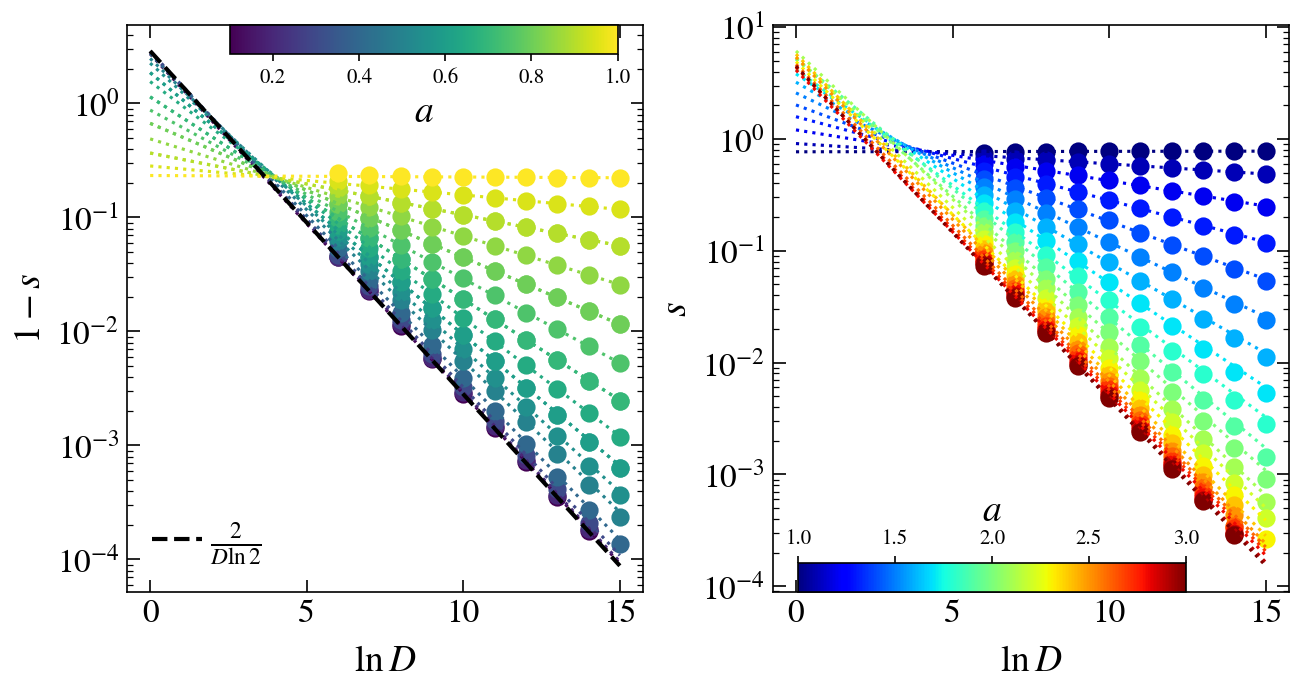

In [33]:
L = 20
w = 2
J = 1
g=0.2
op=0
modello = 'PLRB'
prefix = base_dir(model=modello, d=DIM) + 'Entropy/ManyBody/'

DIM = 1

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 150)

sizes = np.arange(6, 16, 1)
dims = 2**(sizes)

def entropy_fit(L, c, eta):
    return c * np.exp(-eta * L)

g_vals = np.arange(0.1, 1., 0.1)
g_vals2 = np.arange(0.5, 1.02, 0.05)
# g_vals3 = np.arange(2.0, 2.3, 0.05)
g_vals = np.unique( np.array([*g_vals, *g_vals2]))

norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

nu=500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu
for g in g_vals:
    col = s_m.to_rgba(g)
    
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
            
    yy = 1 - S
    axis[0].scatter(sizes, yy, color=col, s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    yy = yy[indices]
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = yy[2:],
                        full_output=True, maxfev=10000)
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[0].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')

cbaxes = axis[0].inset_axes([0.2, 0.95, 0.75, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$a$", fontsize=18)

axis[0].plot(dense_sizes, 2 / np.log(2) / (2**dense_sizes), ls='--', c='k', label=r'$\frac{2}{D\ln{2}}$', lw=2)

g_vals = np.arange(1.0, 3.1, 0.1)
norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='jet', norm=norm)
s_m.set_array([])
for g in g_vals:
    col = s_m.to_rgba(g)
    
    S = np.zeros(sizes.shape); S.fill(np.nan)
    for ii, L in enumerate(sizes):
        name = prefix + info(L=L, J=J, w=w, g=g, model = modello, ext=('_jobid=0.hdf5' if g==0 else '.hdf5') )
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                if g > 0:
                    E = np.array(file.get('mean energies'))
                    dim = E.size
                    ent = np.array(file.get('single_site_entropy'))[0]
                    
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if num == dim or my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if num == dim or my_max >= dim: my_max = dim-1
                    S[ii] = np.mean(ent[my_min : my_max]) / np.log(2)
                else:
                    S[ii] = np.mean(np.array(file.get('single_site_entropy'))[0]) / np.log(2)
        else:
            print(name)
            
    yy = S
    axis[1].scatter(sizes, yy, color=col, s=60)
    indices = np.transpose(np.argwhere(~np.isnan(S)))[0]
    xx = sizes[indices]
    yy = yy[indices]
    pars, pconv, fit_info, msg, _ = fit(entropy_fit,
                        xdata = xx[2:],
                        ydata = yy[2:],
                        full_output=True, maxfev=10000)
    dense_sizes = np.linspace(0, sizes[-1], 10000)
    axis[1].plot(dense_sizes, entropy_fit(dense_sizes, *pars), lw=1.5, color=col, ls = ':')
cbaxes = axis[1].inset_axes([0.05, 0.0, 0.75, 0.05])
cbar = fig.colorbar(s_m, cax = cbaxes, orientation='horizontal')
cbar.set_label(r"$a$", fontsize=18)
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')

fig_help.set_plot_elements(axis[0], xlabel=r"$\ln{D}$", ylabel=r"$1-s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[0], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))
fig_help.set_plot_elements(axis[1], xlabel=r"$\ln{D}$", ylabel=r"$s$", font_size=16, set_legend=True, xscale='linear', yscale='log')
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=16, anchor=(-0.01, -0.01))

fig.subplots_adjust(wspace = 0.25, hspace=0.02)